In [ ]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from scipy.stats import zscore
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils import to_categorical

In [ ]:
train_df = pd.read_csv('/content/UNSW_NB15_training-set.csv')
print(train_df.shape)
train_df.head()

(82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
test_df = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
print(test_df.shape)
test_df.head()

(112656, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6.0,4.0,258.0,172.0,74.087490,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Normal,0.0
1,2,0.649902,tcp,-,FIN,14.0,38.0,734.0,42014.0,78.473372,...,1.0,2.0,0.0,0.0,0.0,1.0,6.0,0.0,Normal,0.0
2,3,1.623129,tcp,-,FIN,8.0,16.0,364.0,13186.0,14.170161,...,1.0,3.0,0.0,0.0,0.0,2.0,6.0,0.0,Normal,0.0
3,4,1.681642,tcp,ftp,FIN,12.0,12.0,628.0,770.0,13.677108,...,1.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,Normal,0.0
4,5,0.449454,tcp,-,FIN,10.0,6.0,534.0,268.0,33.373826,...,1.0,40.0,0.0,0.0,0.0,2.0,39.0,0.0,Normal,0.0


In [ ]:
df = pd.concat([train_df,test_df])
print(df.shape)
df.head()

(194988, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2.0,0.0,496.0,0.0,90909.0902,...,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,Normal,0.0
1,2,0.000008,udp,-,INT,2.0,0.0,1762.0,0.0,125000.0003,...,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,Normal,0.0
2,3,0.000005,udp,-,INT,2.0,0.0,1068.0,0.0,200000.0051,...,1.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,Normal,0.0
3,4,0.000006,udp,-,INT,2.0,0.0,900.0,0.0,166666.6608,...,1.0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,Normal,0.0
4,5,0.000010,udp,-,INT,2.0,0.0,2126.0,0.0,100000.0025,...,1.0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,Normal,0.0


In [ ]:
df.drop(['id', 'label'], axis = 1, inplace = True)
print(df.shape)
print(df.isnull().values.any())

(194988, 43)
True


In [ ]:
df.dropna(axis = 0, inplace = True)
print(df.isnull().values.any())
df.shape

False


(194987, 43)

In [ ]:
X= df.drop(["attack_cat"],axis=1)
Y = df.attack_cat

In [ ]:
def normalize(df, cols):
    result = df.copy()
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [ ]:
object_columns = X.select_dtypes(include=['object'])
column_names = object_columns.columns.tolist()
del object_columns
print(column_names)
X = one_hot(X,column_names)
X = normalize(X,X.columns)

['proto', 'service', 'state']


<ipython-input-11-85e9485e0563>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-11-85e9485e0563>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-11-85e9485e0563>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)


In [ ]:
print(Y.unique())
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

['Normal' 'Reconnaissance' 'Backdoor' 'DoS' 'Exploits' 'Analysis'
 'Fuzzers' 'Worms' 'Shellcode' 'Generic']


In [ ]:
def train_model(model_function, input_shape, num_classes, X_train, Y_train, X_validation, Y_validation):
    accuracies = []
    print(model_function)
    model = model_function(input_shape, num_classes)
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    Y_train_encoded = to_categorical(Y_train, num_classes=num_classes)
    Y_validation_encoded = to_categorical(Y_validation, num_classes=num_classes)

    model.fit(X_train, Y_train_encoded, epochs=10, batch_size=32, verbose=0)
    accuracy = model.evaluate(X_validation, Y_validation_encoded, verbose=0)[1]
    accuracies.append(accuracy)

    predictions = model.predict(X_validation)

    predicted_classes = np.argmax(predictions, axis=1)

    precision = precision_score(Y_validation, predicted_classes, average='weighted')
    recall = recall_score(Y_validation, predicted_classes, average='weighted')
    f1 = f1_score(Y_validation, predicted_classes, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\n\n\n")

    return predictions


In [ ]:
def create_model_1(input_shape, num_classes):
    model = Sequential()
    model.add(Convolution1D(64, kernel_size=122, padding="same", activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
def create_model_2(input_shape, num_classes):
    lstm_output_size = 70

    cnn = Sequential()
    cnn.add(Convolution1D(64, kernel_size=3, padding="same", activation="relu", input_shape = input_shape))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(LSTM(units=lstm_output_size))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation="sigmoid"))
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn

In [ ]:
def create_model_3(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=input_shape[0]))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation = X_validation.values.reshape(X_validation.shape[0], X_validation.shape[1], 1)

In [ ]:
Y_train_encoded = to_categorical(Y_train, num_classes=10)
Y_validation_encoded = to_categorical(Y_validation, num_classes=10)

In [ ]:
pool = Pool(processes=3)

In [ ]:
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])

In [ ]:
df['attack_cat'].head(10)

0    6
1    6
2    6
3    6
4    6
5    6
6    6
7    6
8    6
9    6
Name: attack_cat, dtype: int64

In [ ]:
model_functions = [create_model_1, create_model_2, create_model_3]

with Pool() as pool:
    # Use starmap to train multiple models in parallel and get predictions
    model_predictions = pool.starmap(
        train_model,
        [(model_function, X_train.shape[1:], len(df['attack_cat'].unique()), X_train, Y_train, X_validation, Y_validation) for model_function in model_functions]
    )

weights = [1, 1, 0.6]

ensemble_predictions = np.zeros_like(model_predictions[0])

for i, weight in enumerate(weights):
    weighted_predictions = model_predictions[i] * weight
    ensemble_predictions += weighted_predictions

# Calculate the final ensemble prediction by taking the class with the maximum sum of weighted predictions
ensemble_predictions = np.argmax(ensemble_predictions, axis=1)

ensemble_accuracy = np.mean(ensemble_predictions == Y_validation)

print("Ensemble Model Accuracy:", ensemble_accuracy)

<function create_model_1 at 0x7f274d850790>
<function create_model_2 at 0x7f274d850f70>
Epoch 1/10
Epoch 1/10
4875/4875 [==============================] - 102s 17ms/step - loss: 1.6336 - accuracy: 0.4680
Epoch 2/10
4875/4875 [==============================] - 120s 21ms/step - loss: 0.9481 - accuracy: 0.7248
Epoch 2/10
4875/4875 [==============================] - 81s 17ms/step - loss: 0.6217 - accuracy: 0.7710
Epoch 4/10
4875/4875 [==============================] - 64s 13ms/step - loss: 1.5909 - accuracy: 0.4727
Epoch 5/10
4875/4875 [==============================] - 64s 13ms/step - loss: 1.5909 - accuracy: 0.4727
Epoch 6/10
4875/4875 [==============================] - 86s 18ms/step - loss: 0.5604 - accuracy: 0.7840
Epoch 6/10
4875/4875 [==============================] - 67s 14ms/step - loss: 1.5909 - accuracy: 0.4727
Epoch 8/10
4875/4875 [==============================] - 84s 17ms/step - loss: 0.5444 - accuracy: 0.7904
Epoch 7/10
4875/4875 [==============================] - 65s 13ms/st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1390/4875 [=======>......................] - ETA: 49s - loss: 0.5038 - accuracy: 0.8019 0.2270144473015919
Recall: 0.476460331299041
1393/4875 [=======>......................] - ETA: 49s - loss: 0.5034 - accuracy: 0.8020




4875/4875 [==============================] - 33s 6ms/step - loss: 1.0828 - accuracy: 0.6659
Epoch 2/10
4875/4875 [==============================] - 32s 7ms/step - loss: 0.7126 - accuracy: 0.7439
Epoch 3/10
4875/4875 [==============================] - 23s 5ms/step - loss: 0.6732 - accuracy: 0.7511
Epoch 4/10
  31/4875 [..............................] - ETA: 26s - loss: 0.6799 - accuracy: 0.7490

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  57/4875 [..............................] - ETA: 33s - loss: 0.6852 - accuracy: 0.7418
Precision: 0.786255103359423
  63/4875 [..............................] - ETA: 34s - loss: 0.6861 - accuracy: 0.7450
F1 Score: 0.7657172251497478




4875/4875 [==============================] - 19s 4ms/step - loss: 0.6602 - accuracy: 0.7549
Epoch 5/10
1303/4875 [=======>......................] - ETA: 24s - loss: 0.6571 - accuracy: 0.7546

KeyboardInterrupt: ignored

['proto', 'service', 'state']


<ipython-input-11-85e9485e0563>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-11-85e9485e0563>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-11-85e9485e0563>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)


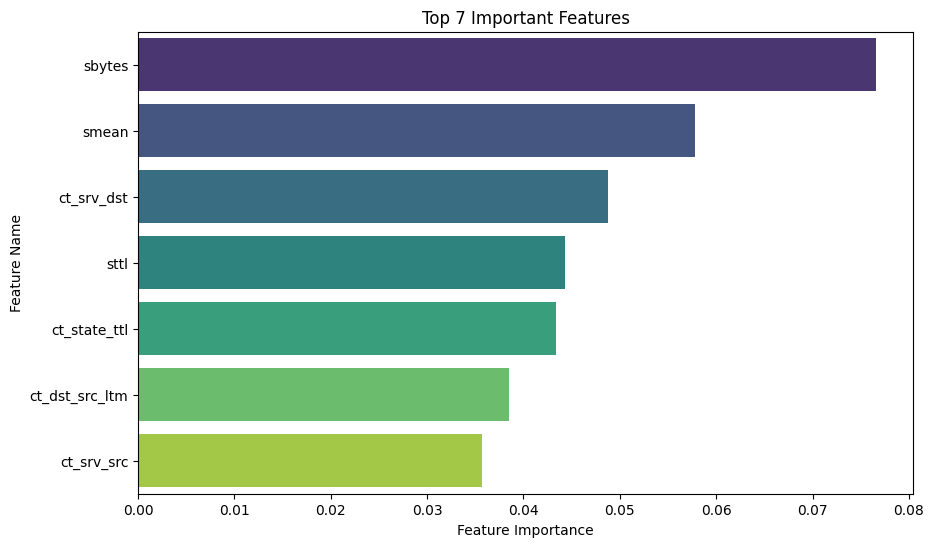

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X_train = df.drop('attack_cat', axis=1)
object_columns = X_train.select_dtypes(include=['object'])
column_names = object_columns.columns.tolist()
del object_columns
print(column_names)
X_train = one_hot(X_train,column_names)
X_train = normalize(X_train,X_train.columns)
y_train = df['attack_cat']
y_train = label_encoder.fit_transform(y_train)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)


rf_classifier = RandomForestClassifier()


rf_classifier.fit(X_train_imputed, y_train)



feature_importances = rf_classifier.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})



feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Select the top 7 important features
top_7_features = feature_importance_df.head(7)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_7_features, palette='viridis')


plt.title('Top 7 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')


plt.show()

In [ ]:
rf_classifier


NameError: ignored